# FBMC demonstration tool

This little jupyter notebook demonstrates how capacity determination is made according to the Flow-based Market coupling method. The notebook consists of several steps, and uses some underlying python scripts to create e.g. grid-data and CGMA data. The overall steps followed in the Notebook are:

### Creating the playground
* Creates a simple power system resembling the Swedish power system
* Divides the power system into bidzones resembling the Noridc power system

### Preparing data at the TSO 
* Forecasts for Generation and load
* Allocation of forecasts to modelled units
* Generation of IGM
* Specification of Contingencies in the IG-100 document (CRAC)
* Specification of Bidding zones in the IG-101 document
* Specification of Generation and Load shift keys in IG-103 document

### Flowbased domain creation 
* Determination of PTDFs per contingency
* Determination oF RAM
* Publication of Flow based Domain




First, import of some needed libraries - specifically Pandapower which forms the core of the application, and suppression of warnings from pandapower.

In [2]:
import pandapower as pp
import pandapower.plotting as pandaplot
from pandapower.timeseries.data_sources.frame_data import DFData
import pandapower.control as control
import pandapower.timeseries as timeseries
import numpy
import json
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os
%matplotlib inline 
warnings.filterwarnings('ignore')

Creating folders to store data to be shared between TSO and RCC

In [3]:
if not os.path.exists('./data/ToRCC'):
    os.mkdir('./data/ToRCC')
if not os.path.exists('./data/IGM'):
    os.mkdir('./data/IGM')

And a folder to store temporary data at the TSO end

In [4]:
if not os.path.exists('./temp'):
    os.mkdir('./temp')

## Grid creation
To get started, we need a power sytstem. Obviously the real power system exists (duh), but for this demonstration tool, we need to create it first.


In the real case at a TSO, data about the power system   would be described in the CIM/CGMES format specifically in the EQ-profile which consists of information of the systems's physical layout including Lines, Loads, Generators etc. For the case of this demonstration, we are using Pandapower and create a small grid resembling (very vaguely)
the Swedish power system. The creation of the system is done in a separate python script and the system is stored as a json file "Grid_EQ.json". As mentioned above, this file is in the real case a CIM/RDF file according to the CIM/CGMES specification.

To understand better what type of information is shared, you can read more in the [CIM/CGMES description from ENSTO-E](https://docstore.entsoe.eu/major-projects/common-information-model-cim/cim-for-grid-models-exchange/standards/Pages/default.aspx)



In [5]:
%run create_larger_grid.py

To provide an overview of the power sytem created, you can plot the power system by running the code below.
The blue dots represent nodes or buses, the triangular symbols are loads, circles are synchronous generators (e.g. Hydro or Nuclear power stations). Finally, the circles with a zigzag pattern inside represent windfarms. The green hashed square represent the slackbus.

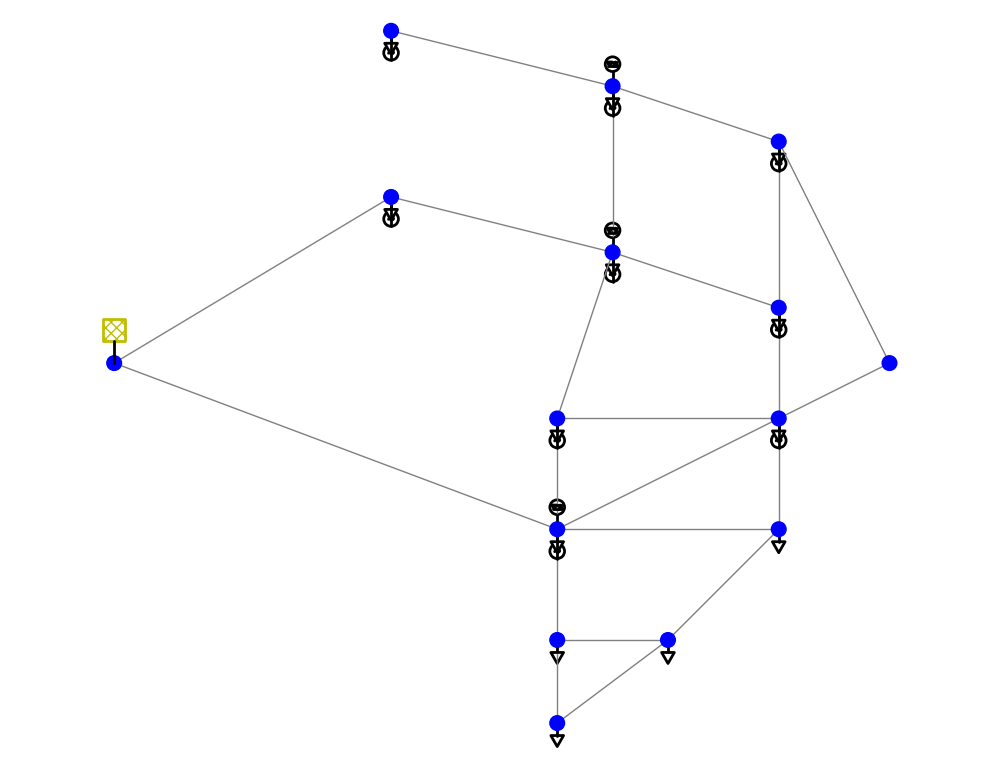

<Axes: >

In [6]:
pandaplot.simple_plot(net, respect_switches=True, plot_loads=True, plot_gens = True, plot_sgens = True)

## Bidzone definition
<p>As an additional layer of information, the bidzones within the grid need to be defined. The below figure illustrates the bidzones of the power system. As can be seen when the power system and bidzone diagrams are placed side-by-side, the links between the bidzones are often represented by several physical powerlines. </p>

<center><img src = "./images/Bidzones.png"></center>

In this demo, the physical components that constitute a bidzone are specified in a python dict named bidzones. The dict contains a list for each bidzone, and this list contains lists of  buses,  generators, windfarms and loads in the bidzone.

In [7]:
bidzones = {'SE1':[[0,1,2],["Hydro1", "Hydro2", "Hydro3","Wind1"],["Load1","Load2","Load3"]],
            'SE2':[[3,4,5],["Hydro4", "Hydro5", "Hydro6","Wind2"],["Load4", "Load5", "Load6"]],
            'SE3':[[6,7,8,9],["Hydro7", "Nuclear2", "Nuclear3", "Wind3"],["Load7","Load8","Load9","Load10"]],
            'SE4':[[10,11,12],[],["Load11","Load12","Load13"]],
            'NO':[[13],[],[]],
            'FI':[[14],[],[]]}

# Preparing data at the TSO end
With the above data prepared, the "playground" for the demonstration has been created and the next steps are representations of actual processes and systems done daily at the TSO and RCC as a part of the capacity allocation.

## Forecasts for generation and load
The first step in the process of createing a D-2 model and forecast invovles forecasting load and generation for all units the system. In addition, to coordinate among several TSOs within the regional security area, a [Common Grid Model alignment (CGMA) process](https://nordic-rcc.net/nordic-common-grid-model-alignment/) has been  established by which forecasts for production and load are sent from TSOs to the RCC, which then creates a aligned forecast for netpositions and flows between bidding zones. These forecasts can be of varying spatial resolution (e.g. bidzone or specific generator), and are usually acquired from several different sources. The CGMA process returns calculated Netpositions for each bidzone in the Nordic region, as well as flow between the bidzones. The forecasts for specific generation types and for load are sourced or developed by the TSO to provide the necessary level of detail in the data. Note that since these forecasts are made before the day-ahead market, there are no production plans for dispatchable generation available.

For this demonstration tool, the forecasts for the 24 timesteps of the day in question (D day) are created in the forecast.py script, which returns json structured files per bidzone named  e.g CGMA_SE1.json, which contain forecasts per bidzone and generation type + load as well as an aggregated NP value per bidzone. Note, that for the real case, the data for Net position and flows on bidzone borders would is the only data used from the CGMA process. The forecasts for generation and load re created by the TSO, or sourced from external vendors.

In [8]:
%run forecast.py

<Figure size 640x480 with 0 Axes>

In the real case, this would constitute various data souces and formats from forecasts, such as production plans from similar preceeding days, timeseries of wind power forecasts etc. The generated files are stored in the /data/CGMA/ folder, and there is one file per bidzone. The files are in json format.

Run the code below for alist fo created files and an example plot for forecasts for SE1

In [9]:
os.listdir('./data/CGMA')

['CGMA_FI.json',
 'CGMA_NO.json',
 'CGMA_SE1.json',
 'CGMA_SE2.json',
 'CGMA_SE3.json',
 'CGMA_SE4.json']

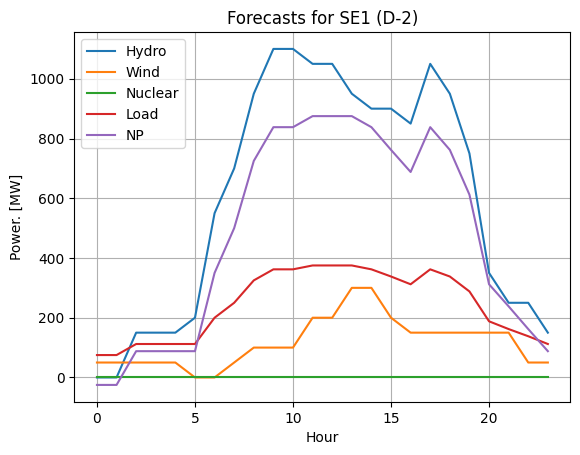

In [10]:
example = pd.read_json('./data/CGMA/CGMA_SE1.json')
example.plot(label="Forecasts for SE1")
plt.xlabel("Hour")
plt.ylabel("Power. [MW]")
plt.title("Forecasts for SE1 (D-2)")
plt.grid()
plt.show()

## Allocation of forecasts to modelled units
Since the forecasts are not of sufficient granularity - i.e. not per individual production unit. The bidzone level forecasts need to be allocated to physical loads and generators within each bidding zone. This is a source of potential error, since the allocation of the forecasts depends on the correctness of the physical model of the grid compared with the actual (future) status of the grid.

The allocate.py script reads the forecasts per bidzone and allocates the forecasts from these to individual generators and loads. For generators, the allocation of plans and forecasts is done based on relative size of installed capacity (S). For loads, the load the forecasts are allocated equally across all loads in the area.  In SvK terms, the allocate.py script represents the allocation of data to units done in the LAFA application prior to generating the IGM. See slide 4 and on in this [presentation to the Svk Driftråd](https://www.svk.se/siteassets/om-oss/organisation/vara-rad/driftradet/2020/drad_4_20_natkoder.pdf)

The data created would in CIM/CGMES terms correspond to the SSH file, which specifies the load (both active and reactive power) and generation (only active power)  for each timestep. Note, that the forecasts generated above only contained the active (P) values for loads and generation. The reactive production needs to be estimated based on the type of node. In this demonstration, the data is stored in a json file named "Grid_SSH.json"

In [11]:
%run allocate.py

<Figure size 640x480 with 0 Axes>

To see examples of the forecasts divided ber unit in SE1, run the below code

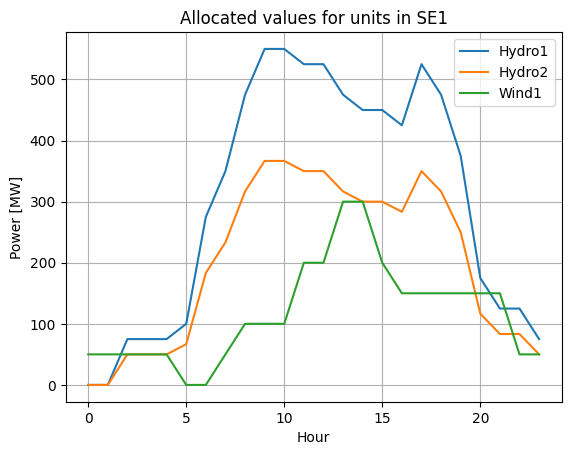

In [12]:
data = pd.read_json("./data/Grid_SSH.json")
example = data[['Hydro1','Hydro2','Wind1']].copy()
example.plot(label="Individual values in SE1")
plt.xlabel("Hour")
plt.ylabel("Power [MW]")
plt.title("Allocated values for units in SE1")
plt.grid()
plt.show()

A possible source of error here - beyond that of inaccuracies in the forecasts themselves - is how the allocation to units is done and whether all physical units are included in the allocaation process. The first question regarding method for allocation is in this demo done by allocating production to nodes in proportion to their rated power in $MVA$. Also, in this demo all units that exist in the power sytem are included in the allocation process. A reason that this may not be true  in the real case is that physical units may not be modelled in the EQ file, and hence be left outside of the modeling completely, although still of course contribute to power flows in the power system, see Slide 6 and on, in [presentation to the Svk Driftråd](https://www.svk.se/siteassets/om-oss/organisation/vara-rad/driftradet/2020/drad_4_20_natkoder.pdf).

## Generation of IGM
With load and generation forecasts allocated to the modelled units, the generation of the IGM can be done. This is done by running load-flow calculations for each of the 24 timesteps using the grid as represented in the EQ-file. The resulting voltages and lines flows are stored in a D-2 IGM, which consists of the basecase for the Coordinated Capacity Calcuation. One possible source of error here is that the grid model as represented in the EQ_file created in D-2  is not a good representation of the grid topology for the operational day D.


The code in the cell below reads the forecasts created by the allocation script from the GridSSH.json file and allocates the forecasts to the units that are included in the system.

In [13]:
ssh = pd.read_json('./data/Grid_SSH.json')
ds = DFData(ssh)
load_input = control.controller.const_control.ConstControl(net, element='load', element_index=net.load.index,
                                  variable='p_mw', data_source=ds, profile_name=['Load1_p', 'Load2_p', 'Load3_p', 'Load4_p', 'Load5_p','Load6_p', 'Load7_p', 'Load8_p','Load9_p','Load10_p','Load11_p','Load12_p','Load13_p'])
load_q_input = control.controller.const_control.ConstControl(net, element='load', element_index=net.load.index,
                                  variable='q_mvar', data_source=ds, profile_name=['Load1_q', 'Load2_q', 'Load3_q', 'Load4_q', "Load5_q",'Load6_q','Load7_q','Load8_q','Load9_q','Load10_q','Load11_q','Load12_q','Load13_q'])
hydro_input = control.controller.const_control.ConstControl(net, element='gen', element_index=[0,1,2,3,4,5,7],
                                  variable='p_mw', data_source=ds, profile_name=['Hydro1','Hydro2', 'Hydro3', 'Hydro4', 'Hydro5','Hydro6','Hydro7'])
nuclear_input = control.controller.const_control.ConstControl(net, element='gen', element_index=[6,8],
                                  variable='p_mw', data_source=ds, profile_name=['Nuclear2', 'Nuclear3'])
wind_input = control.controller.const_control.ConstControl(net, element='sgen', element_index=net.sgen.index,
                                  variable='p_mw', data_source=ds, profile_name=['Wind1','Wind2','Wind3'])

The code in the cell below specifies which of the variables in the coming powerflow studies that should be logged and stored for each timestep.

In [14]:
ow = timeseries.OutputWriter(net, output_path="./temp/", output_file_type=".json")
ow.init_log_variables(net)
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_bus', 'va_degree')
ow.log_variable('res_bus', 'p_mw')
ow.log_variable('res_gen', 'p_mw')
ow.log_variable('res_gen', 'q_mvar')
ow.log_variable('res_line', 'p_from_mw')
ow.log_variable('res_line', 'p_to_mw')
ow.log_variable('res_line', 'q_from_mvar')
ow.log_variable('res_line','loading_percent')
ow.log_variable('gen', 'p_mw')
ow.log_variable('gen', 'q_mvar')
ow.log_variable('load', 'p_mw')
ow.log_variable('load', 'q_mvar')
ow.log_variable('res_ext_grid','p_mw')

Finally, one AC powerflow calcualtion is run per timestep. As can be seen from the printout after the cell, the powerflow has some trouble converging for some of the timesteps since there is a poor match for reactive power Q. This is quite understandable since the generator nodes are started with no Q value specified, and the iterative solution fails to find solutions due to poor starting value. 

In [15]:
timeseries.run_timeseries(net, time_steps=24, numba=False)

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
  8%|▊         | 2/24 [00:01<00:12,  1.83it/s]Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
 29%|██▉       | 7/24 [00:01<00:02,  7.33it/s]Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
 46%|████▌     | 11/24 [00:01<00:01, 11.71it/s]Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mvar]: 'q_mvar'
Error at index [0, 1, 2, 3, 4, 5, 6, 7, 8] for gen[q_mv

The below code packages the output from the pandapower powerflow and the logged data  stored in the ./temp folder into a coherent D-2 structure consisting of one net object with results data from the powerflow per timestep. In CIM/CGMES terms the python list IGM holds 24 complete networks with EQ, SSH and SV data. In this demonstration, the data is stored in 24 individual json files.

In [16]:
%run create_IGM.py
os.listdir('./data/IGM')

['D2_IGM_0.json',
 'D2_IGM_1.json',
 'D2_IGM_10.json',
 'D2_IGM_11.json',
 'D2_IGM_12.json',
 'D2_IGM_13.json',
 'D2_IGM_14.json',
 'D2_IGM_15.json',
 'D2_IGM_16.json',
 'D2_IGM_17.json',
 'D2_IGM_18.json',
 'D2_IGM_19.json',
 'D2_IGM_2.json',
 'D2_IGM_20.json',
 'D2_IGM_21.json',
 'D2_IGM_22.json',
 'D2_IGM_23.json',
 'D2_IGM_3.json',
 'D2_IGM_4.json',
 'D2_IGM_5.json',
 'D2_IGM_6.json',
 'D2_IGM_7.json',
 'D2_IGM_8.json',
 'D2_IGM_9.json']

<Figure size 640x480 with 0 Axes>

The code below plots some examples of data from the 24 D-2 IGM files.
* D-2 Forecasted flows on the border between SE2 and SE3
* D-2 Forecasted flows on some lines in SE3
* D-2 Forecasted voltage profile across the nodes in SE4

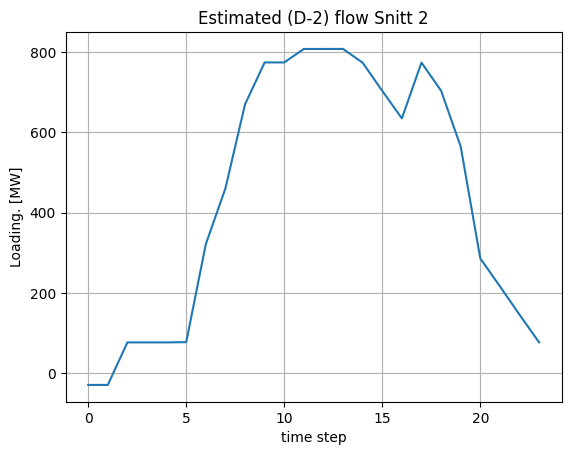

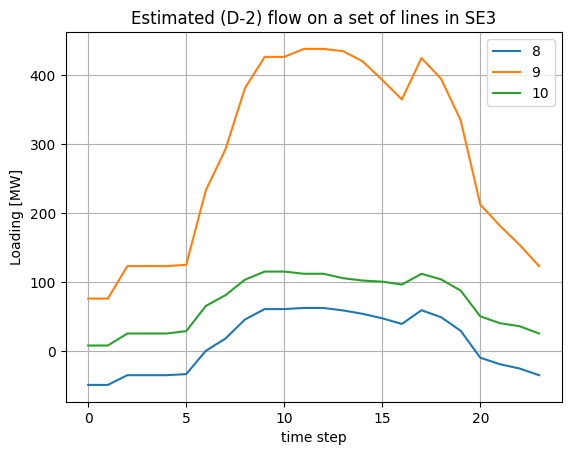

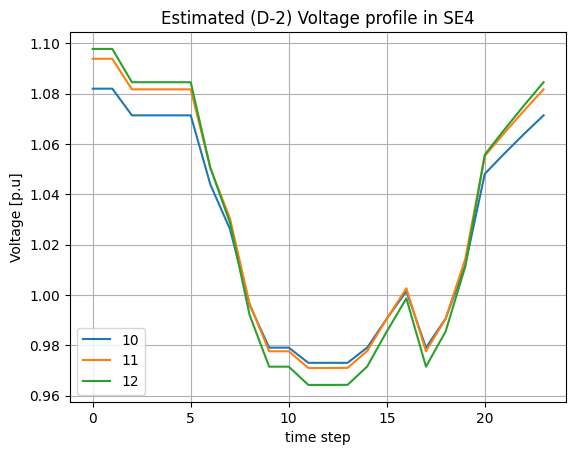

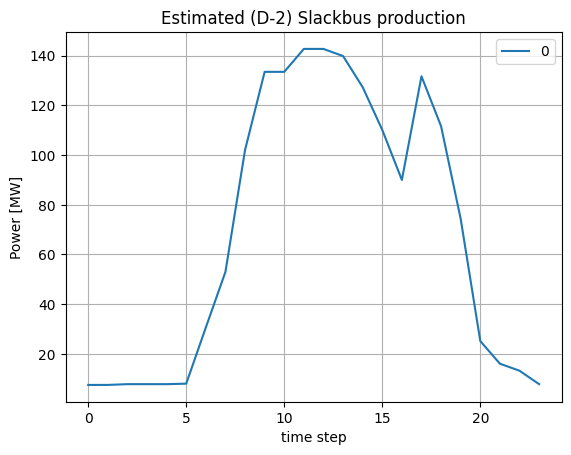

In [17]:
line_load_file = os.path.join("./temp/", "res_line", "p_from_mw.json")
line_load = pd.read_json(line_load_file)

snitt2 = line_load[[6,7]].copy()
snitt2.sum(axis=1).plot(label="line_flows")
plt.xlabel("time step")
plt.ylabel("Loading. [MW]")
plt.title("Estimated (D-2) flow Snitt 2")
plt.grid()


some_lines = line_load[[8,9,10]].copy()
some_lines.plot(label="line_flows")
plt.xlabel("time step")
plt.ylabel("Loading [MW]")
plt.title("Estimated (D-2) flow on a set of lines in SE3")
plt.grid()

voltage_profile_file = os.path.join("./temp/", "res_bus", "vm_pu.json")
voltage_profile = pd.read_json(voltage_profile_file)
voltages_in_SE4 = voltage_profile[[10,11,12]].copy()
voltages_in_SE4.plot(label="Voltages")
plt.xlabel("time step")
plt.ylabel("Voltage [p.u]")
plt.title("Estimated (D-2) Voltage profile in SE4")
plt.grid()

slackbus_file = os.path.join("./temp/", "res_ext_grid", "p_mw.json")
slackbus = pd.read_json(slackbus_file)
slackbus.plot(label="Power")
plt.xlabel("time step")
plt.ylabel("Power [MW]")
plt.title("Estimated (D-2) Slackbus production")
plt.grid()


For an overview of the grid at a certain timestep, modify the N parameter in the cell below and run the code.

In [18]:
N = 13
pp.plotting.plotly.pf_res_plotly(IGM[N])

The created  IGM, which consists of 24 AC-powerflow "snapshots" of forecasted grid states is then sent to RCC to be merged into a Common Grid Model (CGM). The RCC will run a power flow on the IGM and the merged CGM to validate the data. If everything checks out i.e. the loadflow converges also for the combined grid model CGM, the completed CGM is returned to the TSO to be used in the following studies. [The CGM creation process is further described at Nordic-RCC homepage](https://nordic-rcc.net/services/common-grid-model-cgm/).

For the case of this demonstration, the generated IGM comprises the entire grid and no merging is necessary and we assume that the data passes validation. 

## Data needed in addition to the IGM
In addition to the D-2 IGM, each TSO needs to provide some additional data to the RCC, this includes: 
* [IG-100 - Contingency List, Remedial Actions and Additional Constraints - CRAC](https://eepublicdownloads.entsoe.eu/clean-documents/EDI/Library/crac/CRAC_implementation_guide_v2r3.pdf)
* IG-101 - Bidding Zone definitions
* [IG-103 - Generation and Load shift keys - G(L)SK](https://docstore.entsoe.eu/Documents/EDI/Library/lsig/161027_MC_TOP_9a_Generation_and_Load_Shift_Key_Implementation_Guide_v2.pdf)
* [IG-110 - Critical Network Elements with Contingencies (IG-110 file)](https://eepublicdownloads.entsoe.eu/clean-documents/EDI/Library/critical_network_element_implementation/Critical_Network_Element_IG_v2.2-20190212.pdf)

The below sections describe how this has been implemented in this demonstration tool

## Specification of Contingencies in the IG-100 document (CRAC)
Starting with the IG-100 file, it should contain a list of contingencies,  possible remedial actions and additional constraints.  Focusing on the contingencies it is important to note the following terms:
* CNE - Critical Network Element - a single network element which may limit the power transfer between bidding zones
* CDC - Combined Dynamic Constraint - a combination of network elements (usually a group of lines) may limit the power transfer between bidding zones
* CNEC - Critical Network with Contincency - a network element which may limit the power transfer between bidding zones in the case of a specific contingency

Furthermore, it is important to note that critical elements may reside within a bidding zone and still impact the flow between zones. Also, all critical elements are directional, i.e. if necessary the same ciritcal element may need to be monitored for flows in both directions.

The above implies that the capacity allocation needs to consider both the N-0 situation, where the network is intact and no contingency is active and an N-1 situation when a contingency is active. For the N-0 case, the CNE and CDC constraints need to be evaluated. For the N-1 case the CNECs are evaluated, this needs to be done for each CNEC. And again, this needs to be done bi-directionally

In this demonstration the CRAC file has been simplified into a python list of lists. The critical elements are stored as a list on the form:

* Type of contingency = {line, gen, cdc}
* index of element with fault= {0,..n}
* index of critical element 0 {0,..n}, for cdc type contingency this is a list of indices
* direction {True|False} - True means direction follows definition in GridEQ
* limit to respect {value}  Transient and/or Permanent Avalable Transfer Limit, $F_{max}$
* name, {string} useful to separate direction of contingency in presentation

The parameters of the contingencies - i.e. why is a certain device is a constraint - and how to know which parameter to monitor in case of a contingency - are determined beforehand (off-line) by power system analysts at the TSO. 

The contingency list is stored in the /ToRCC folder as a json file named "IG-100.json" 

In [19]:
contingencies = []  # empty list of contingencies

# The format of the contingency list is:
# [type (str), index of object with contingency (int), index of object to watch (int), value to monitor (str), limit (int), name of contingency (str)]

# First, a critical element that is critical even without a contingency, for a line, this implies a thermal limitation
contingencies.append(['line',10,10,True,800,net.line.at[10, 'name'] + '->'])
contingencies.append(['line',10,10,False,800,net.line.at[10, 'name']+ '<-'])
contingencies.append(['line',7,7,True,750,net.line.at[7, 'name'] + '->'])
contingencies.append(['line',7,7,False,750,net.line.at[7, 'name']+ '<-'])

#Second, elements that are critical in the case of a contingency.
contingencies.append(['line',2,3,True,900, 'X_' + net.line.at[2, 'name'] + ' ' + net.line.at[3, 'name'] + '->']) # A failure of line 2, leading to possible overload on line 3, monitor p_mw versus limit F_max of 800
contingencies.append(['line',2,3,False,900, 'X_' + net.line.at[2, 'name'] + ' ' + net.line.at[3, 'name'] + '<-']) # A failure of line 2, leading to possible overload on line 3, monitor p_mw versus limit F_max of 800, northbound flow
contingencies.append(['line',6,7,True,900, 'X_' + net.line.at[6, 'name'] + ' ' + net.line.at[7, 'name'] + '->']) # A failure of line 6, leading to possible overload on line 7, monitor p_mw versus limit F_max of 800
contingencies.append(['line',6,7,False,900, 'X_' + net.line.at[6, 'name'] + ' ' + net.line.at[7, 'name'] + '<-']) # A failure of line 6, leading to possible overload on line 7, monitor p_mw versus limit F_max of 800, northbound flow
#contingencies.append(['line',13,14,True,900, 'X_' + net.line.at[13, 'name'] + ' ' + net.line.at[14, 'name'] + '->']) # A failure of line 13, leading to possible overload on line 14, monitor p_mw versus limit F_max of 800
#contingencies.append(['line',13,14,False,900, 'X_' + net.line.at[13, 'name'] + ' ' + net.line.at[14, 'name'] + '<-']) # A failure of line 13, leading to possible overload on line 14, monitor p_mw versus limit F_max of 800, northbound flow

#Third, a Combined Dynamic Constraint, which is a type of CNE where the combination of flows can lead to a critical siutuation 
contingencies.append (['CDC',2,3,True,900,'PTC SE1->SE2']) # A Combined Dynamic Constraint representing the Power Transfer Corridor from SE1 to SE2, Flow max 800MW
contingencies.append (['CDC',6,7,True,900,'PTC SE2->SE3']) # A Combined Dynamic Constraint representing the Power Transfer Corridor from SE2 to SE3, Flow max 800MW

print (contingencies)

with open('./data/ToRCC/IG-100.json', 'w', encoding='utf-8') as f:
    json.dump(contingencies, f, ensure_ascii=False, indent=4)

[['line', 10, 10, True, 800, 'L10->'], ['line', 10, 10, False, 800, 'L10<-'], ['line', 7, 7, True, 750, 'L7->'], ['line', 7, 7, False, 750, 'L7<-'], ['line', 2, 3, True, 900, 'X_L2 L3->'], ['line', 2, 3, False, 900, 'X_L2 L3<-'], ['line', 6, 7, True, 900, 'X_L6 L7->'], ['line', 6, 7, False, 900, 'X_L6 L7<-'], ['CDC', 2, 3, True, 900, 'PTC SE1->SE2'], ['CDC', 6, 7, True, 900, 'PTC SE2->SE3']]


## Specification of Bidding zones in the IG-101 document
Second, we need to define the bidding zones in the system. It may appear superflous at this stage, since we have generated data in the CGMA process assuming that the bidding zones are already defined. The reason behind the step is that bidding zone information in the CGMA process is not retained at the RCC.  This is reflected in this demonstration by the fact that we have already defined a bidzone dict and used in the forecasting and CGMA process.

In this demonstration, the bidding zone are created as a dictionary of lists which contain indices and names of buses, generators and loads which belong to each zone. The definition is (for completeness) stored in a a json file named "IG-101.json"

In [20]:
'''
To compensate for a "feature" in the Jupyter notebook that leads to an unintentional
conversion of the bidzones dict into a list when it is used by the allocat.py script we
redefine the bidzones here again to regain the dict structure
'''

bidzones = {'SE1':[[0,1,2],["Hydro1", "Hydro2","Hydro3", "Wind1"],["Load1","Load2","Load3"]],
            'SE2':[[3,4,5],["Hydro4", "Hydro5","Hydro6", "Wind2"],["Load4", "Load5", "Load6"]],
            'SE3':[[6,7,8,9],["Hydro7", "Nuclear2", "Nuclear3", "Wind3"],["Load7","Load8","Load9","Load10"]],
            'SE4':[[10,11,12],[],["Load11","Load12","Load13"]],
            'NO':[[13],[],[]],
            'FI':[[14],[],[]]}

with open('./data/ToRCC/IG-101.json', 'w', encoding='utf-8') as f:
    json.dump(bidzones, f, ensure_ascii=False, indent=4)

## Specification of Generation and Load shift keys in IG-103
Thereafter,the TSO needs to prepare the Generation and Load shift key strategy to be used in the determination of the Flow based domain.  The GLSK strategy will determine how the generators and/or loads in a bidding zone picks up an increase in Netposition during the determination of the Flow based domain performed at RCC.
<div>
<center><img src="./images/GSK_strategies.PNG" width=500></center>
</div>
The table above shows the possible strategies that are available in the Capacity Calcualtion process. The GLSK strategy is applied per biddingzone and in theory it could be updated for each timestep. This is however not realistic, and instead the choice of strategy remains stable over time and is for Sweden the same for all bidzones.

In this demonstration, the GLSK determination is done in two steps. First a dict containting the strategies to use per area is created and stored as a json file. 

In [21]:
GLSK_strategies = {"SE1":3,"SE2":3,"SE3":3,"SE4":7,"NO":3,"FI":3}
with open('./temp/GLSK_strategies.json','w') as file:
    json.dump(GLSK_strategies, file)

By applying a the GLSK strategy to the whole system, or to an area of a system we have generated a corresponding IG-103 file, which in this case is a list of ratios to be applied to the individual generators and loads in an area in order to distribute a change in the Netposition of a bidzone across nodes within the zone. The script below  takes the chosen GLSK strategies as input and stores the result in in the /ToRCC folder as a json file named "IG-103.json"

In [22]:
%run generate_GLSK.py

<Figure size 640x480 with 0 Axes>

To provide an example of the GSKs, the code below reads the IG-103 file and prints the generation shift keys for the Hydrostations in  SE1.

In [23]:
glsk_example = pd.read_json('./data/ToRCC/IG-103.json')
SE1_glsk = glsk_example[['SE1']].copy()
pd.set_option('display.max_colwidth', None)
SE1_glsk.iloc[1,:]

SE1    {'Hydro1': 0.5, 'Hydro2': 0.33333333333333304, 'Hydro3': 0.16666666666666602}
Name: 1, dtype: object

# Handing over to the RCC

At this stage we have created four main pieces of data to send to the RCC. This includes:
* An IGM consisting of 24 files with AC powerflow snapshots of the power system
* A list of critical network elements in the IG-100 file
* Definition of the bidding zones in the IG-101 file
* GLSKs for all generators and loads in the IG-103 file

With all the above data the RCC is ready determine flow based domain, which consists of a RAM (Remaining Availability Margin) value and associated the PTDF (Power Transfer Distribution Factors)s for each CDC and CNE with active or non-active contingency. The overall workflow for the [Coordinated Capacity Calculation methodology is described at the Nordic RCC homepage](https://nordic-rcc.net/services/coordinated-capacity-calculation-ccc/)

The first step invovles determining the PTF

## Determining Node to Slack PTDFs
The first step invovles determining the PTDFs from each node (generating unit or load) to the slack bus. The PTDF is defined as the change in flow on a line (here limited to those defined in the IG-100 file) caused by an increase (or decrease for loads) of 1MW for each unit defined in the IG-103 file.

Put simply, this is done by looping through all units defined in the IG-103 file - i.e. generators or loads included in the GSK strategy and vary the power value for each by 1MW and record the change in flow for each element defined in the IG-100 file, i.e. CDCs and CNEs with or without contingencies applied. Since this requires several load flow calculations, a DC load-flow is used since this is more computationally efficient. 

First step is that the RCC reads the files that have been shared by the TSO. In addition a specific list of all the Critical elements is created . This list holds specifically the elements that may limit the transfers given a contingency (CNEC) or those that may be limiting even without a contingency (CNE).

In [24]:
with open('./data/ToRCC/IG-100.json') as json_data:
    contingencies = json.load(json_data)
with open('./data/ToRCC/IG-101.json') as json_data:
    bidzones = json.load(json_data) 
with open('./data/ToRCC/IG-103.json') as json_data:
    nodes = json.load(json_data) 

nodes_to_perturb = []
for area in bidzones.keys():
    nodes_in_area = list(nodes[0][area].keys())
    for n in nodes_in_area:
        nodes_to_perturb.append(n)

cnec = []
for c in contingencies:
    cnec.append(c[5])
print (nodes_to_perturb)
print (cnec)

['Hydro1', 'Hydro2', 'Hydro3', 'Hydro4', 'Hydro5', 'Hydro6', 'Hydro7', 'Load11', 'Load12', 'Load13']
['L10->', 'L10<-', 'L7->', 'L7<-', 'X_L2 L3->', 'X_L2 L3<-', 'X_L6 L7->', 'X_L6 L7<-', 'PTC SE1->SE2', 'PTC SE2->SE3']


Thereafter a dataframe to hold the PTDFs for all the 24 timesteps is created. 

In [25]:
list_of_PTDF_n2s = []

Then, PTDFs for each contingency (i.e. CNE, CNEC and/or CDC) as defined in the IG-100 file is analysed for each timestep. In the code below, the outer loop iterates through all 24 timesteps of the day, and appends the results to the list created above. In the two inner loops, the PTDFn_2 for each contingency for each node (load or generator) defined in the IG-103 file is determined.

For CNEs, i.e. ciritcal elements without a contingency, the PTDF_n2s are determined by first running an DC powerflow on the basecase, i.e. the grid at N-0, then apply a 1MW netproduction change at each node and run the DC loadflow again. FOr CNECs, the base-case is first modified to an N-1 situation, and DC loadflows are used to determine the PTDFs.

For this demonstration, we are assuming that the grid topology (as represented in the GridEQ.json file) does not change for any of the timesteps, which means that for these DC loadflow calualtions, the results, i.e. the PTDFs, are similar for all timesteps.

In [26]:
for n in range (24):
    base_case = pp.from_json('./data/IGM/D2_IGM_' + str(n)   + '.json')
    PTDF_n2s = pd.DataFrame()
    PTDF_n2s['CNE(C)']=pd.Series(cnec)
    for node in nodes_to_perturb:
        ptdf_list = []
        for c in contingencies:
            base = pp.pandapowerNet(base_case)
            if (c[1] != c[2]):
                base.line.at[c[1],'in_service'] = False
            shift_net = pp.pandapowerNet(base)
            if 'Load' in node:
                shift_net.load.loc[shift_net.load.name == node, 'p_mw'] -= 1
            else:
                shift_net.gen.loc[shift_net.gen.name == node, 'p_mw'] += 1
            pp.rundcpp(shift_net)
            pp.rundcpp(base)
            if (c[3]):
                result = shift_net.res_line.p_from_mw - base.res_line.p_from_mw
            else:
                result = shift_net.res_line.p_to_mw - base.res_line.p_to_mw
            if c[0] == 'line':     
                ptdf = result[c[2]]
            else:
                ptdf =  result[c[1]] + result[c[2]]
            ptdf_list.append(ptdf)
        PTDF_n2s[node] = pd.Series(ptdf_list)
    list_of_PTDF_n2s.append(PTDF_n2s)

**$PTDF_{n2s}$**  is a $N_{c} x N_{n}$ matrix, where $N_{c}$ is the number of contingencies (CNE, CNEC and CDC) to evaulate, and $N_{n}$ is the number of nodes in the GLSKs. The code below prints the **$PTDF_{n2s}$** for one timestep (N=13)

In [27]:
print(list_of_PTDF_n2s[13])

         CNE(C)    Hydro1    Hydro2    Hydro3    Hydro4    Hydro5    Hydro6  \
0         L10->  0.248916  0.248916  0.283898  0.103890  0.207781  0.281667   
1         L10<- -0.248916 -0.248916 -0.283898 -0.103890 -0.207781 -0.281667   
2          L7->  0.204989  0.204989  0.227004  0.089551  0.179102  0.380580   
3          L7<- -0.204989 -0.204989 -0.227004 -0.089551 -0.179102 -0.380580   
4     X_L2 L3->  0.624037  0.624037  0.624037 -0.032329 -0.064658 -0.145341   
5     X_L2 L3<- -0.624037 -0.624037 -0.624037  0.032329  0.064658  0.145341   
6     X_L6 L7->  0.284809  0.284809  0.281410  0.144403  0.288805  0.436607   
7     X_L6 L7<- -0.284809 -0.284809 -0.281410 -0.144403 -0.288805 -0.436607   
8  PTC SE1->SE2  0.624037  0.624037  0.624037 -0.032329 -0.064658 -0.145341   
9  PTC SE2->SE3  0.284809  0.284809  0.281410  0.144403  0.288805  0.436607   

     Hydro7    Load11    Load12    Load13  
0  0.199976  0.033318  0.085591  0.056289  
1 -0.199976 -0.033318 -0.085591 -0.056289 

## Determining the GSK matrix

To determine the $PTDF_{z2s}$, i.e. the flows between bidzones  the GSK node to zone matrix $GSK_{n2z}$ needs first to be determined. By Using the $GSK_{n2z}$ matrix, the $PTDF_{z2s}$ can be expressed as 
</p>
<img style="align: center;" src="./images/Equation_2.PNG">

The $GSK_{n2z}$ matrix specifies the proportion that each node represents in a net position change of the corresponding bidding zone. The **columns** of the matrix are bidding zones and the rows are the **nodes**, which are the generators (or loads) for which a GSK key is defined in the IG-103 file). The sum of each column shall equal one.

The code below determines $GSK_{n2z}$ for each timestep. In this demo, since we are not modifying the GSK strategies during the day all $GSK_{n2z}$ are similar.

In [28]:
list_of_GSK_n2z = []
total_units = len(nodes_to_perturb)
cols = bidzones.keys()
for n in range (24):
    GSK_n2z = pd.DataFrame()
    for area in nodes[n].keys():
        for unit in nodes[n][area].items():
            GSK_n2z.at[unit[0], area] = unit[1]
            GSK_n2z.at[unit[0], 'NO'] = 0
            GSK_n2z.at[unit[0], 'FI'] = 0          
    GSK_n2z = GSK_n2z.fillna(0)
    GSK_n2z = GSK_n2z[['SE1','SE2','SE3','SE4','NO','FI']]
    list_of_GSK_n2z.append(GSK_n2z)

To visualise the $GSK_{n2z}$ matrix, the code below prints the matrix for one timestep (N=4). As can be seen, the $GSK_{n2z}$ matrix is a is a $N_{n} x N_{b}$ matrix, where $N_{n}$ is the number of nodes (generation or load) that will pickup a NP change in the bidzone, and $N_{b}$ the number of bidzones in the system.

In [29]:
print (list_of_GSK_n2z[4])

             SE1  SE2  SE3       SE4   NO   FI
Hydro1  0.500000  0.0  0.0  0.000000  0.0  0.0
Hydro2  0.333333  0.0  0.0  0.000000  0.0  0.0
Hydro3  0.166667  0.0  0.0  0.000000  0.0  0.0
Hydro4  0.000000  0.4  0.0  0.000000  0.0  0.0
Hydro5  0.000000  0.4  0.0  0.000000  0.0  0.0
Hydro6  0.000000  0.2  0.0  0.000000  0.0  0.0
Hydro7  0.000000  0.0  1.0  0.000000  0.0  0.0
Load11  0.000000  0.0  0.0  0.333333  0.0  0.0
Load12  0.000000  0.0  0.0  0.333333  0.0  0.0
Load13  0.000000  0.0  0.0  0.333333  0.0  0.0


<p>Therafter the PTDF matrix  $PTDF_{z2s}$ for zone to slack values  can be determined. This is done according to Equation 2 in Article 13 of the Nordic CCM.</p>
<img style="align: center;" src="./images/Equation_2.PNG">

The code below modifies the generated matrices (pandas dataFrames) into a format (numpy matrix) which is suitable for mathamatical operations.

In [30]:

list_of_PTDF_n2s_mtx = []
list_of_GSK_n2z_mtx = []
for j in range (24):
    list_of_PTDF_n2s_mtx.append(list_of_PTDF_n2s[j].select_dtypes('number').values)
    list_of_GSK_n2z_mtx.append(list_of_GSK_n2z[j].values)

So, now the matrices re stripped down to the values, still the  **$PTDF_{n2s}$** matris is a $N_{c} x N_{n}$ matrix, where $N_{c}$ is the number of contingencies (CNE, CNEC and CDC) to evaulate, and $N_{n}$ is the number of nodes in the GLSKs.

In [31]:
print(list_of_PTDF_n2s_mtx[6])


[[ 0.24891567  0.24891567  0.28389783  0.10389043  0.20778087  0.28166726
   0.19997599  0.03331845  0.08559084  0.05628886]
 [-0.24891567 -0.24891567 -0.28389783 -0.10389043 -0.20778087 -0.28166726
  -0.19997599 -0.03331845 -0.08559084 -0.05628886]
 [ 0.2049887   0.2049887   0.22700359  0.08955093  0.17910185  0.38057963
  -0.03089727 -0.05508625 -0.06140746 -0.05786402]
 [-0.2049887  -0.2049887  -0.22700359 -0.08955093 -0.17910185 -0.38057963
   0.03089727  0.05508625  0.06140746  0.05786402]
 [ 0.62403724  0.62403724  0.62403724 -0.03232886 -0.06465773 -0.14534103
   0.01115425  0.01988674  0.02216876  0.02088954]
 [-0.62403724 -0.62403724 -0.62403724  0.03232886  0.06465773  0.14534103
  -0.01115425 -0.01988674 -0.02216876 -0.02088954]
 [ 0.28480904  0.28480904  0.28141037  0.14440273  0.28880546  0.43660686
  -0.10165016 -0.08223376 -0.08838429 -0.08493653]
 [-0.28480904 -0.28480904 -0.28141037 -0.14440273 -0.28880546 -0.43660686
   0.10165016  0.08223376  0.08838429  0.08493653]


The  $GSK_{n2z}$ matrix is a is a $N_{n} x N_{b}$ matrix, where $N_{n}$ is the number of nodes (generation or load) that will pickup a NP change in the bidzone, and $N_{b}$ the number of bidzones in the system.

In [32]:
print(list_of_GSK_n2z_mtx[6])

[[0.5        0.         0.         0.         0.         0.        ]
 [0.33333333 0.         0.         0.         0.         0.        ]
 [0.16666667 0.         0.         0.         0.         0.        ]
 [0.         0.4        0.         0.         0.         0.        ]
 [0.         0.4        0.         0.         0.         0.        ]
 [0.         0.2        0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.         0.33333333 0.         0.        ]]


With those steps done, we are ready to calcualte the **$PTDF_{z2s}$** matrix, which forms one core component of the Flowbased domain. The code below does this for all 24 timesteps and re-creates a dataframe with the derived values (for pretty printing).

In [33]:
list_of_PTDF_z2s_mtx = []
list_of_PTDF_z2s = []
for k in range (24):
    list_of_PTDF_z2s_mtx.append(numpy.matmul(list_of_PTDF_n2s_mtx[k],list_of_GSK_n2z_mtx[k]))
    list_of_PTDF_z2s.append(pd.DataFrame(list_of_PTDF_z2s_mtx[k], columns = ['SE1','SE2','SE3','SE4','NO','FI']))
    list_of_PTDF_z2s[k]['CNE(C)']=pd.Series(cnec)
    list_of_PTDF_z2s[k] = list_of_PTDF_z2s[k][['CNE(C)','SE1','SE2','SE3','SE4','NO','FI']]

As can be seen below, the **$PTDF_{z2s}$** matrix consists of one row per CNE with opur without contingency, and one column per bidding zone. The values in the matrix are intepreted as the change in flow on a CNE(C) resulting from a change in the Netposition of a bidzone

In [34]:
print (list_of_PTDF_z2s[13])
print(list_of_PTDF_z2s_mtx[13])

         CNE(C)       SE1       SE2       SE3       SE4   NO   FI
0         L10->  0.254746  0.181002  0.199976  0.058399  0.0  0.0
1         L10<- -0.254746 -0.181002 -0.199976 -0.058399  0.0  0.0
2          L7->  0.208658  0.183577 -0.030897 -0.058119  0.0  0.0
3          L7<- -0.208658 -0.183577  0.030897  0.058119  0.0  0.0
4     X_L2 L3->  0.624037 -0.067863  0.011154  0.020982  0.0  0.0
5     X_L2 L3<- -0.624037  0.067863 -0.011154 -0.020982  0.0  0.0
6     X_L6 L7->  0.284243  0.260605 -0.101650 -0.085185  0.0  0.0
7     X_L6 L7<- -0.284243 -0.260605  0.101650  0.085185  0.0  0.0
8  PTC SE1->SE2  0.624037 -0.067863  0.011154  0.020982  0.0  0.0
9  PTC SE2->SE3  0.284243  0.260605 -0.101650 -0.085185  0.0  0.0
[[ 0.25474603  0.18100197  0.19997599  0.05839938  0.          0.        ]
 [-0.25474603 -0.18100197 -0.19997599 -0.05839938  0.          0.        ]
 [ 0.20865785  0.18357704 -0.03089727 -0.05811924  0.          0.        ]
 [-0.20865785 -0.18357704  0.03089727  0.05811924

### Determine $F_{max}$ and $F_{ref}$ values per CNE
For each CNE provided by the TSO, the RCC needs to establish the $F_{max}$ values for each CNE, CDC and CNE with an applied contingency, this is in accordance with article 17 of the CMM. Equation 8 below specifies how this is done </p>

<center><img src="./images/Equation_8.PNG"></center>

The $I_{max}$ value is provided by the TSO in the form of technical thermal limits of the line adjusted for temperature (not in this demo). The voltage $U$ is determined from AC powerflows on the CGM, for each CNE and for each CNEC with the contingency applied. The current limits are provided in the IGM as an EQDIFF file modifying (or possibly not) the individual current limits for each line.

These $F_{max}$ values calculated by the RCC shall be compared with the values provided by the TSO in the contingency list (IG-110), the value to use in determining the FB domain is the lowest of the two.

In addition to the $F_{max}$ values, the $F_{ref}$ values need to be determined. These are the flows on each CNE or CDC in the N-0 case and on each CNEC in the N-1 case that exist in the CGM/IGM sent by the TSO.

In [35]:

# contingencies.append(['line',12,12,True,750,net.line.at[12, 'name'] + '->'])

with open('./data/ToRCC/IG-100.json') as json_data:
    contingencies = json.load(json_data)

list_of_FMax_values = []
list_of_Fref_values = []
for n in range (24):
    Fmax_values = []
    Fref_values = []
    grid_model = pp.from_json('./data/IGM/D2_IGM_' + str(n) +'.json')
    for c in contingencies:
        if c[0] == 'line':
            if c[1] == c[2]:     # If the two values are equal, the constraint is a CNE without contingency
                if c[3]:
                    Fref = grid_model.res_line.at[c[2],'p_from_mw']
                else:
                    Fref = grid_model.res_line.at[c[2],'p_to_mw']
                I_max = grid_model.line.at[c[2], "max_i_ka"]
                from_bus = int(grid_model.line.at[c[2],"from_bus"])
                to_bus = int(grid_model.line.at[c[2],"to_bus"])
                U = 400*(grid_model.res_bus.at[from_bus, "vm_pu"] + grid_model.res_bus.at[to_bus, "vm_pu"])/2       # 400kV is base voltage in the system
            else:
                net_N_1 = pp.pandapowerNet(grid_model)
                net_N_1.line.at[c[1],'in_service'] = False
                pp.runpp(net_N_1)
                if c[3]:
                    Fref = net_N_1.res_line.at[c[2],'p_from_mw']
                else:
                    Fref = net_N_1.res_line.at[c[2],'p_to_mw']
                I_max = net_N_1.line.at[c[2], "max_i_ka"]
                from_bus = int(net_N_1.line.at[c[2],"from_bus"])
                to_bus = int(net_N_1.line.at[c[2],"to_bus"])
                U = 400*(net_N_1.res_bus.at[from_bus, "vm_pu"] + net_N_1.res_bus.at[to_bus, "vm_pu"])/2  # 400kV is base voltage in the system
            cos_fi = 0.95
            Fmax = pow(3,0.5)*U*I_max*cos_fi
            if Fmax > c[4]:
                Fmax = c[4]
            if not c[3]:
                Fmax = 0-Fmax

        else:
            Fmax = c[4]
            if c[3]:
                Fref = grid_model.res_line.at[c[1],'p_from_mw'] + grid_model.res_line.at[c[2],'p_from_mw']
            else:
                Fref = grid_model.res_line.at[c[1],'p_to_mw'] + grid_model.res_line.at[c[2],'p_to_mw']
        Fmax_values.append(abs(Fmax))
        Fref_values.append(Fref)
    list_of_FMax_values.append(pd.Series(Fmax_values).T)
    list_of_Fref_values.append(pd.Series(Fref_values).T)


For each timestep we now have a corresponding vector of $F_{max}$ and $F_{ref}$ values for each CNE(C). The below code prints a fleshed out version (with CNE(C) names added) $F_{max}$ vector.

In [36]:
F_max = list_of_FMax_values[13].copy()
to_print = pd.concat ([pd.Series(cnec),F_max], axis = 1)
to_print.columns = ['CNE(C)','F_max']
print(to_print)


         CNE(C)       F_max
0         L10->  750.324410
1         L10<-  750.324410
2          L7->  750.000000
3          L7<-  750.000000
4     X_L2 L3->  868.796685
5     X_L2 L3<-  868.796685
6     X_L6 L7->  868.796685
7     X_L6 L7<-  868.796685
8  PTC SE1->SE2  900.000000
9  PTC SE2->SE3  900.000000


The below code prints a fleshed out version (with CNE(C) names added) $F_{ref}$ vector.

In [37]:
F_ref = list_of_Fref_values[13].copy()
to_print = pd.concat ([pd.Series(cnec),F_ref], axis = 1)
to_print.columns = ['CNE(C)','F_ref']
print(to_print)

         CNE(C)       F_ref
0         L10->  105.606981
1         L10<- -104.910174
2          L7->  364.151067
3          L7<- -353.261110
4     X_L2 L3->  374.935259
5     X_L2 L3<- -366.289521
6     X_L6 L7->  497.265494
7     X_L6 L7<- -476.815129
8  PTC SE1->SE2  579.528835
9  PTC SE2->SE3  807.585777


## Determining $F_{0}$
$F_{0}$ is the flow between bidzones for the case where each bidzone has a Netposition of zero. Intuitively, it may seem strange that there would be flows between bidzones when each area is in balance. Since the areas are abstract market concepts overlaid on a physical grid, there may still be physical flows between the areas, typical examples are loop flows in a structure with meshed bidzones.

$F_{0}$ is determined according to Equation 9 from the Nordic CCM methodology.

<center><img style="align=center" src="./images/Equation_9.PNG"></center>

First, we need to determine the vector $NP_{ref}$ which holds the values of the Netpositions from the CGM/IGM. The code below loops through all times steps of the CGMA data and reads the Netpositions per are and strores them in one vector per timestep.

In [38]:
list_of_NP_vectors = []
for m in range (24):
    NP_vector = pd.DataFrame(columns = bidzones.keys())
    for area in bidzones.keys():
        cgma = pd.read_json('./data/CGMA/CGMA_' + area + '.json')
        NP_vector.at[m,area] = cgma.at[m,'NP']
    list_of_NP_vectors.append(NP_vector)

To show the content of the $NP_{ref}$ vector, the code below prints it for one timestep (N=13). As can be seen it holds the NP values per bidzones as was defined at the start of the process.

In [39]:
print (list_of_NP_vectors[13])

    SE1  SE2   SE3   SE4 NO FI
13  875  617  -742  -750  0  0


Next is to convert the format to matrices for convenience, and then determine the $F_{0}$ for each timestep value according to Equation 9 above.

In [40]:
list_of_F0_values = []
for w in range (24):
    C = list_of_Fref_values[w].to_numpy()
    A = numpy.atleast_2d(C).T
    B = numpy.matmul(list_of_PTDF_z2s_mtx[w],list_of_NP_vectors[w].values.T)
    F0_values = A-B
    list_of_F0_values.append(F0_values)

To show the content of the $F_{0}$ vector, the code below prints it for one timestep (N=13). As can be seen it holds the $F_{0}$ values per CNE(C) 

In [41]:
example = pd.DataFrame(columns = ['CNE(C)','F0'])
example['CNE(C)'] = pd.Series(cnec)
F = []
for n in range (len(contingencies)):
    F.append(list_of_F0_values[13][n][0])
example['F0'] = pd.Series(F)
print(example)


         CNE(C)          F0
0         L10->  -36.792290
1         L10<-   37.489097
2          L7->    1.793213
3          L7<-    9.096744
4     X_L2 L3-> -105.213237
5     X_L2 L3<-  113.858975
6     X_L6 L7->  -51.552914
7     X_L6 L7<-   72.003280
8  PTC SE1->SE2   99.380339
9  PTC SE2->SE3  258.767369


## Determine RAM per CNEC

Finally, we are getting to the point where we can determine the **RAM** - Remaining Available Margin which is the remaining capacity per CNE(C), that will be communicated to the market in conjunction with tthe PTDFs. The RAM value is determiend as per Equation 10 below.

<p><img style="align: center;" src="./images/Equation_10.PNG"></p>

For the sake of this demonstration, we are ignoring the $F_{RA}$ values which represent the capacity that can be made available on a CNE(C) after applying some remedial action. The TSO is obliged to include all non-costly Remdial actions in the determination of the **RAM**, put simply a non-costly RA is one that does not interfere with the market, e.g. topology actions. Similarly, this demonstration also ignores the $F_{AAC}$ value which represents capacity on the CNE(C) which has already been allocated in an earlier process before the FB capacity determination.

Finally, the $F_{RM}$ value is a margin allocated per CNE(C) to account for modelling errors in the process that may lead to a too high value being allocated to the market, which in turn may lead to unwanted consequewnces in operation, thereby reducing reliability. A high $F_{RM}$ value, reduces the available capacity, and therefore imposes a more conservative operation of the grid. The Nordic CCM agreement specifies that the $F_{RM}$ shall be set so that it captures 95% of all modelling errors. Since (again) this demonstration is limited in scope, it is not possible to determine the modelling error beforehand, and instead the margin has been set to 50%. This is implemented by multiplying the determined **RAM** value with 0.95 in the code below.

In [42]:
list_of_RAM_values = []
print()
for h in range (24):
    RAM_values =(numpy.atleast_2d(list_of_FMax_values[h].to_numpy()).T)-(list_of_F0_values[h])
    list_of_RAM_values.append(RAM_values)

To show the content of the **RAM** vector, the code below prints it for one timestep (N=13). As can be seen it holds the **RAM** values per CNE(C)

In [43]:
example = pd.DataFrame(columns = ['CNE(C)','RAM'])
example['CNE(C)'] = pd.Series(cnec)
R = []
for n in range (len(contingencies)):
    R.append(list_of_RAM_values[13][n][0])
example['RAM'] = pd.Series(R)
print(example)

         CNE(C)         RAM
0         L10->  787.116700
1         L10<-  712.835313
2          L7->  748.206787
3          L7<-  740.903256
4     X_L2 L3->  974.009922
5     X_L2 L3<-  754.937710
6     X_L6 L7->  920.349599
7     X_L6 L7<-  796.793405
8  PTC SE1->SE2  800.619661
9  PTC SE2->SE3  641.232631


We are finally at the point to create the complete FB domain, which consists of the **RAM** vector and the $PTDF_{z2s}$ matrix. In keeping with the previous this is done for each of the 24 timesteps.

In [44]:
list_of_FB_domains = []
for n in range (24):
    R = []
    for m in range (len(contingencies)):
        R.append(list_of_RAM_values[n][m][0])
    RAM_series = pd.Series(R)
    FB_domain = pd.concat([RAM_series,list_of_PTDF_z2s[n]], axis=1)
    FB_domain = FB_domain.rename({0:'RAM'}, axis=1)
    FB_domain = FB_domain.reindex(['CNE(C)','RAM','SE1','SE2','SE3','SE4'], axis=1)
    list_of_FB_domains.append(FB_domain)
print (list_of_FB_domains[13])

         CNE(C)         RAM       SE1       SE2       SE3       SE4
0         L10->  787.116700  0.254746  0.181002  0.199976  0.058399
1         L10<-  712.835313 -0.254746 -0.181002 -0.199976 -0.058399
2          L7->  748.206787  0.208658  0.183577 -0.030897 -0.058119
3          L7<-  740.903256 -0.208658 -0.183577  0.030897  0.058119
4     X_L2 L3->  974.009922  0.624037 -0.067863  0.011154  0.020982
5     X_L2 L3<-  754.937710 -0.624037  0.067863 -0.011154 -0.020982
6     X_L6 L7->  920.349599  0.284243  0.260605 -0.101650 -0.085185
7     X_L6 L7<-  796.793405 -0.284243 -0.260605  0.101650  0.085185
8  PTC SE1->SE2  800.619661  0.624037 -0.067863  0.011154  0.020982
9  PTC SE2->SE3  641.232631  0.284243  0.260605 -0.101650 -0.085185


The below is an experiment

[[875]
 [617]
 [-742]
 [-750]
 [0]
 [0]]
[ 0.         -0.06786284  0.01115425  0.02098168  0.          0.        ]
[-65.88409112827061]


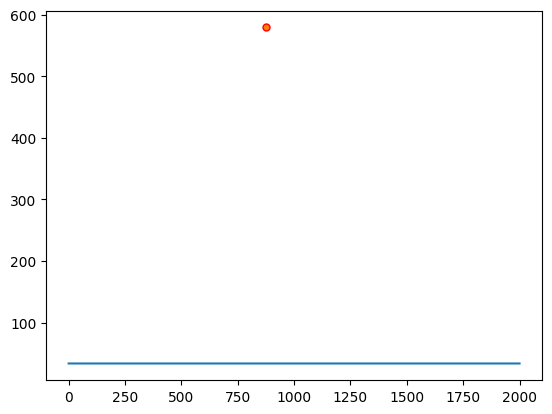

In [47]:
snitt_1_PTDF = list_of_PTDF_z2s_mtx[13][8,:]
save = snitt_1_PTDF[0]
SE1_sweep = save*numpy.arange(-1000,1001,1)
snitt_1_PTDF[0] = 0
NPs = list_of_NP_vectors[13].values.T
print(NPs)
snitt_1_flows = numpy.matmul(snitt_1_PTDF,NPs)
print (snitt_1_PTDF)
print (snitt_1_flows)

line = list_of_F0_values[13][8]+snitt_1_flows+SE1_sweep
plt.plot(line)
SE1_NP_basecase_x = list_of_NP_vectors[13]['SE1']
SE1_NP_basecase_y = list_of_Fref_values[13][8]

plt.plot(SE1_NP_basecase_x,SE1_NP_basecase_y, marker = 'o', markersize = 5, markeredgecolor = 'red')



